In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 
pd.options.display.float_format = '{:,.2f}'.format

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv') 
# df = pd.read_csv('jammedaxis27109-infinite-matchhistory.csv')
# df.info()
# df.describe().transpose()

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] > '2024-02-04']

df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)

dfr = df[df['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
# dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
# dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0, 'Draw': 0.5})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                           (dfr['Outcome'].cumsum() + 
                            dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('dfNS.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               172 non-null    int64         
 1   Date                172 non-null    datetime64[ns]
 2   SeasonNumber        172 non-null    int64         
 3   SeasonVersion       172 non-null    int64         
 4   Map                 172 non-null    object        
 5   Category            172 non-null    object        
 6   Rank                172 non-null    int64         
 7   Outcome             172 non-null    float64       
 8   Accuracy            172 non-null    float64       
 9   DamageDone          172 non-null    int64         
 10  DamageTaken         172 non-null    int64         
 11  ShotsFired          172 non-null    int64         
 12  ShotsLanded         172 non-null    int64         
 13  ShotsMissed         172 non-null    int64         

In [4]:
dfr.tail(2)

,index,Date,SeasonNumber,SeasonVersion,Map,Category,Rank,Outcome,Accuracy,DamageDone,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
170,878,2024-03-15 01:51:00,6,1,Recharge,King of the Hill,5,0.00,46.02,4741,...,1.11,1.18,52.58,26.96,9.28,53.74,7.29,2.74,1073,0.60
171,879,2024-03-15 02:02:38,6,1,Aquarius,Slayer,5,0.00,56.68,4771,...,1.11,1.18,52.60,26.96,9.38,53.66,7.28,2.72,1064,0.59


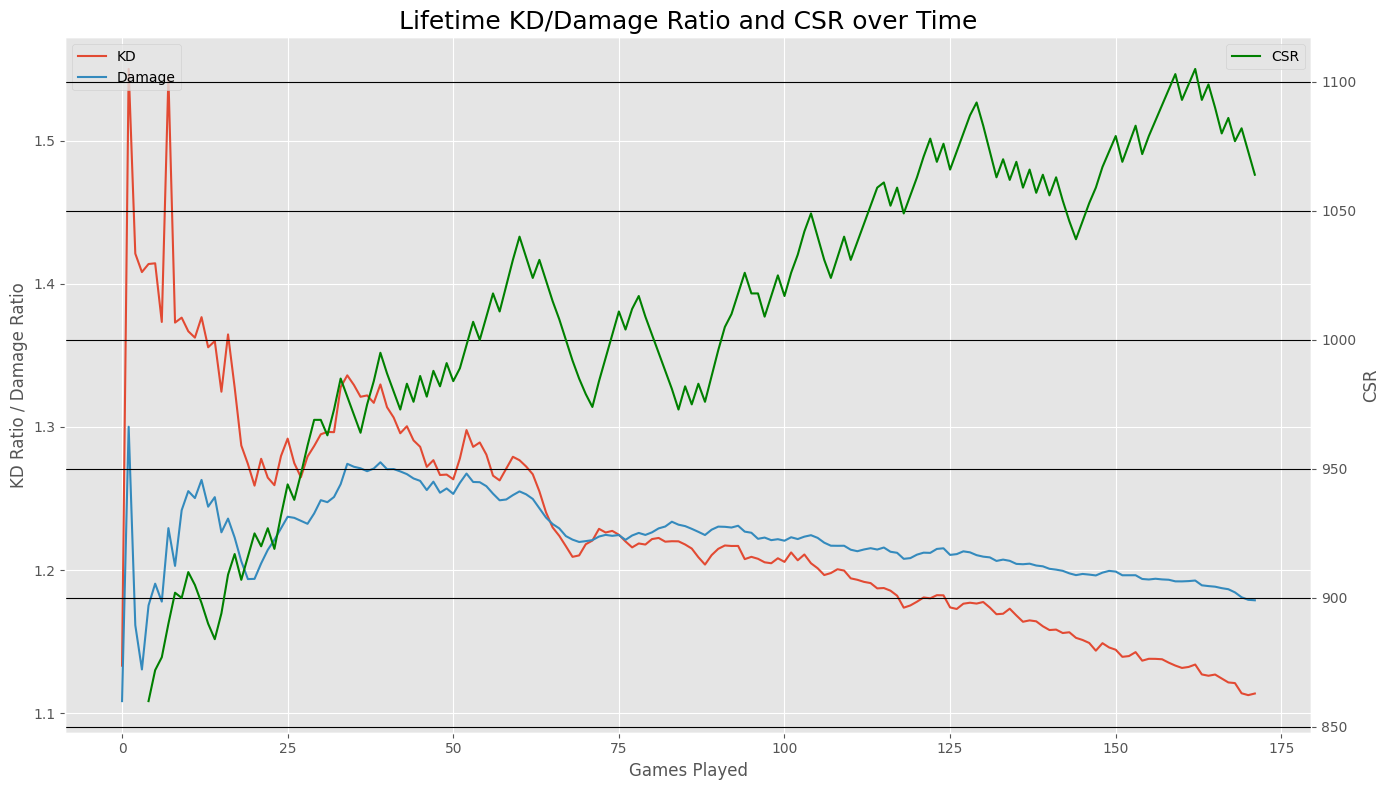

In [5]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][4:], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True, color='black')
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

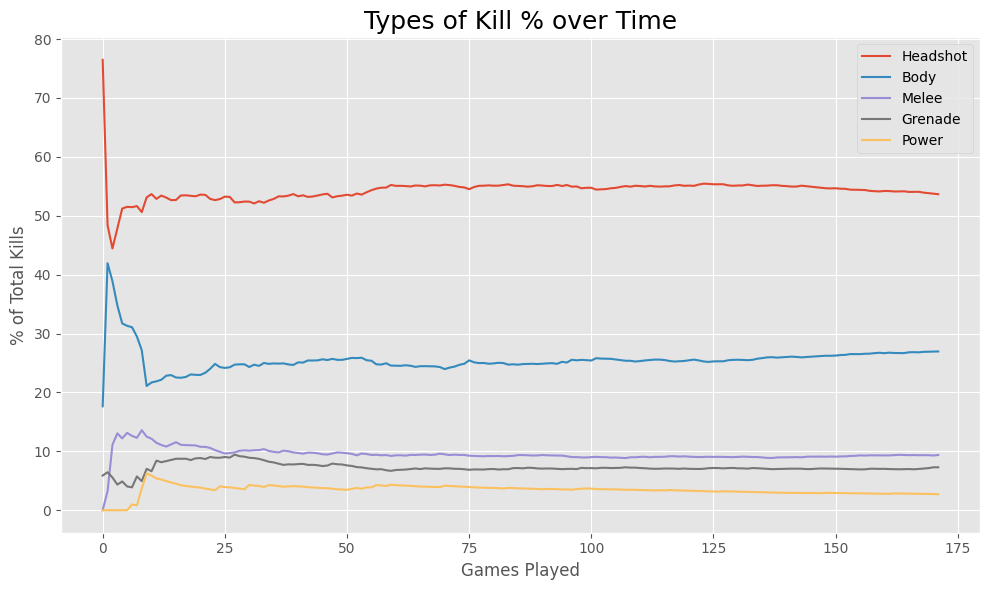

In [6]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeHSPct'], label='Headshot')
plt.plot(dfr['LifetimeBodyPct'], label='Body')
plt.plot(dfr['LifetimeMeleePct'], label='Melee')
plt.plot(dfr['LifetimeGrenadePct'], label='Grenade')
plt.plot(dfr['LifetimePowerPct'], label='Power')
plt.title('Types of Kill % over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
plt.legend(loc='best')
plt.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

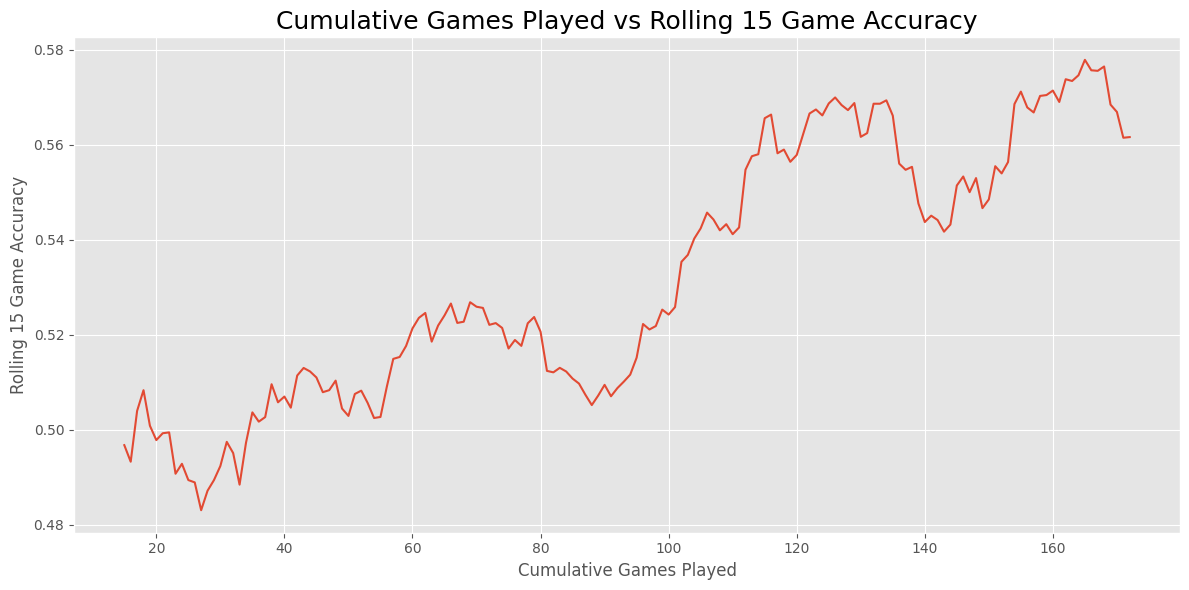

In [7]:
mod = 15

# Line graph of cumulative games played and rolling 50 game accuracy
dfr['CumulativeGames'] = np.arange(1, len(dfr) + 1)
dfr['RollingAccuracy'] = dfr['ShotsLanded'].rolling(window=mod).sum() / dfr['ShotsFired'].rolling(window=mod).sum()

plt.figure(figsize=(12, 6))
plt.plot(dfr['CumulativeGames'], dfr['RollingAccuracy'])
plt.title(f'Cumulative Games Played vs Rolling {mod} Game Accuracy', fontsize=18)
plt.xlabel('Cumulative Games Played')
plt.ylabel(f'Rolling {mod} Game Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


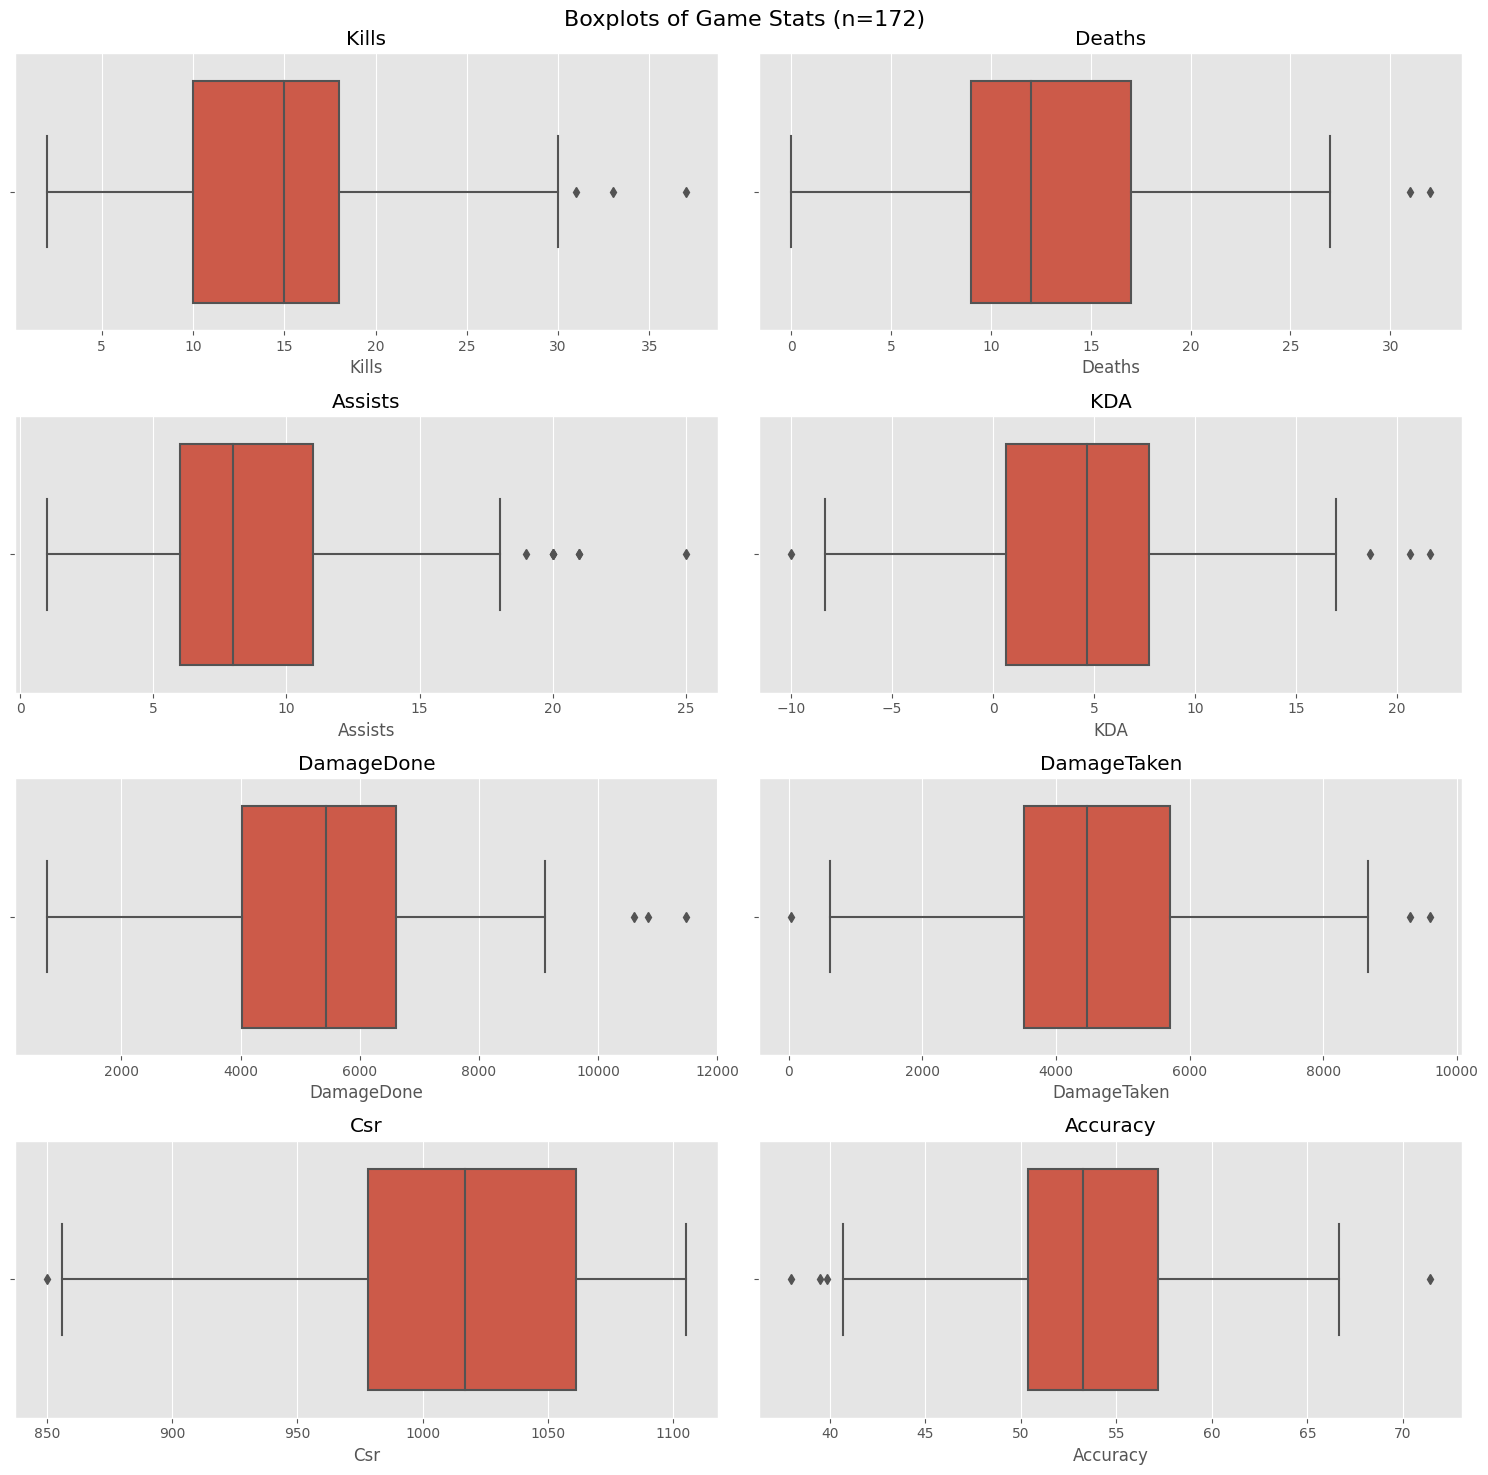

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle(f'Boxplots of Game Stats (n={len(dfr)})', fontsize=16)
plt.tight_layout()
# plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [9]:
dfrcc = dfr.groupby(['Category','Map']).agg(
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Category', 'Map'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

Wins  Losses  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                           
King of the Hill Live Fire     4       0     56      60       47       23210   
Oddball          Streets       9       1    168     147       99       60458   
Slayer           Live Fire     7       1     84      76       53       30215   
                 Solitude      9       2    113     103       93       44364   
Oddball          Recharge      6       2    140     111      100       49393   
CTF 3 Captures   Forbidden     9       4    147     105       76       55064   
Slayer           Recharge      2       1     33      25       11       10514   
King of the Hill Solitude      6       3    136     126      101       51536   
Strongholds      Solitude      5       3    148     115       93       48733   
Oddball          Live Fire     5       3    132     153       93       51789   
CTF 5 Captures   Aquarius      8       5    233     171      127       83782   
Strongholds      Live Fire     4       4    137     109       69       47340   
                 Recharge      3       3     91      88       55       34329   
CTF 3 Captures   Empyrean      8       9    296     268      129      106743   
                 Argyle        7       9    236     216      121       89338   
Slayer           Streets       3       5     67      76       54       29725   
                 Aquarius      2       4     56      63       44       25107   
King of the Hill Recharge      4      11    232     216      169       89556   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
King of the Hill Live Fire        20682     1.00          47.00     54.73   
Oddball          Streets          49516     0.90         118.52     54.95   
Slayer           Live Fire        27332     0.88          67.35     54.28   
                 Solitude         38364     0.82          95.73     51.39   
Oddball          Recharge         38917     0.75          96.00     52.93   
CTF 3 Captures   Forbidden        39707     0.69         114.33     51.84   
Slayer           Recharge          9196     0.67          25.57     46.69   
King of the Hill Solitude         42958     0.67         101.68     53.10   
Strongholds      Solitude         40816     0.62          93.27     54.14   
Oddball          Live Fire        49003     0.62         108.90     54.16   
CTF 5 Captures   Aquarius         63507     0.62         143.15     54.15   
Strongholds      Live Fire        38886     0.50          94.02     57.17   
                 Recharge         33425     0.50          77.10     50.63   
CTF 3 Captures   Empyrean         95639     0.47         216.28     51.95   
                 Argyle           73859     0.44         185.60     52.92   
Slayer           Streets          27356     0.38          65.28     52.48   
                 Aquarius         23495     0.33          49.18     53.55   
King of the Hill Recharge         76993     0.27         166.45     50.97   

                             KD  DamageRatio  Dmg/Life  Dmg/KA  ExDmg/Life  \
Category         Map                                                         
King of the Hill Live Fire 0.93         1.12    386.83  225.34       42.13   
Oddball          Streets   1.14         1.22    411.28  226.43       74.44   
Slayer           Live Fire 1.11         1.11    397.57  220.55       37.93   
                 Solitude  1.10         1.16    430.72  215.36       58.25   
Oddball          Recharge  1.26         1.27    444.98  205.80       94.38   
CTF 3 Captures   Forbidden 1.40         1.39    524.42  246.92      146.26   
Slayer           Recharge  1.32         1.14    420.56  238.95       52.72   
King of the Hill Solitude  1.08         1.20    409.02  217.45       68.08   
Strongholds      Solitude  1.29         1.19    423.77  202.21       68.84   
Oddball          Live Fire 0

In [10]:
dfrcc = dfr.groupby('Map').agg(
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,Dmg/KA,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,,,,,,
Live Fire,20,8,409,398,262,3391,6149,152554,135903,0.71,317.27,1.03,1.12,383.30,227.35,41.84,0.66
Solitude,20,8,397,344,287,3483,6583,144633,122138,0.71,290.68,1.15,1.18,420.44,211.45,65.39,0.83
Forbidden,9,4,147,105,76,1238,2388,55064,39707,0.69,114.33,1.40,1.39,524.42,246.92,146.26,0.72
Streets,12,6,235,223,153,2054,3798,90183,76872,0.67,183.80,1.05,1.17,404.41,232.43,59.69,0.69
Aquarius,10,9,289,234,171,2557,4735,108889,87002,0.53,192.33,1.24,1.25,465.34,236.72,93.53,0.73
Empyrean,8,9,296,268,129,2473,4760,106743,95639,0.47,216.28,1.10,1.12,398.29,251.16,41.43,0.48
Recharge,15,17,496,440,335,4274,8357,183792,158531,0.47,365.12,1.13,1.16,417.71,221.17,57.41,0.76
Argyle,7,9,236,216,121,2038,3851,89338,73859,0.44,185.60,1.09,1.21,413.60,250.25,71.66,0.56


In [11]:
dfrcc = dfr.groupby('Category').agg(
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
    
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,Dmg/KA,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,,,,,,
Oddball,20,6,440,411,292,3610,6678,161640,137436,0.77,323.42,1.07,1.18,393.28,220.82,58.89,0.71
Slayer,23,13,353,343,255,3364,6439,139925,125743,0.64,303.12,1.03,1.11,407.94,230.14,41.35,0.74
CTF 5 Captures,8,5,233,171,127,1924,3553,83782,63507,0.62,143.15,1.36,1.32,489.95,232.73,118.57,0.74
Strongholds,12,10,376,312,217,3037,5617,130402,113127,0.55,264.38,1.21,1.15,417.96,219.90,55.37,0.70
CTF 3 Captures,24,22,679,589,326,5749,10999,251145,209205,0.52,516.22,1.15,1.20,426.39,249.90,71.21,0.55
King of the Hill,14,14,424,402,317,3824,7335,164302,140633,0.50,315.13,1.05,1.17,408.71,221.73,58.88,0.79


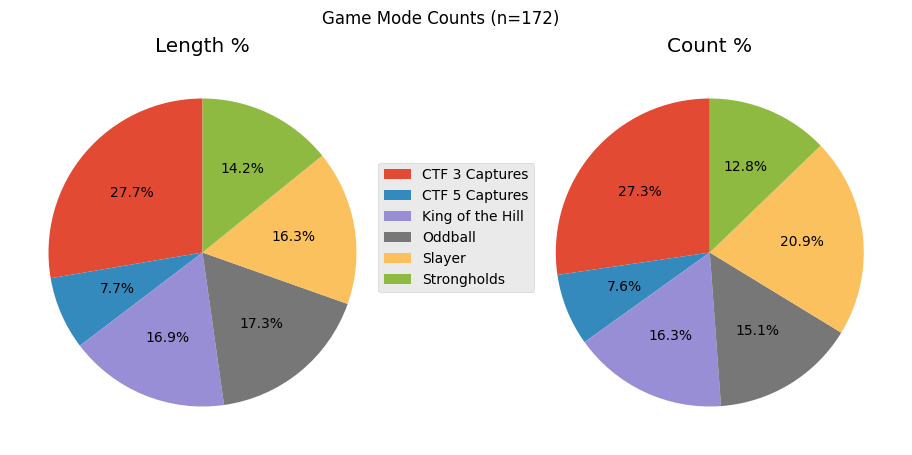

In [12]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
# Update the title of the plot to include the total game count
fig.suptitle(f'Game Mode Counts (n={totalcount})')

ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")

plt.show()

In [13]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)


print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Totals
Total Games: 172
Total Kills: 2505
Total Deaths: 2228
Total Assists: 1534
----------------------------
Overall
Overall KD: 1.16
Average Kills: 13.36
Average Deaths: 11.53
Average Assists: 8.27
Average Accuracy: 52.95
Average Damage Done: 5414
Average Damage Taken: 4591
Damage Ratio: 1.18
Win-Loss: 101-70
----------------------------
Wins
Overall KD: 1.31
Average Kills: 13.86
Average Deaths: 10.54
Average Assists: 8.89
Average Accuracy: 53.86
Average Damage Done: 5215
Average Damage Taken: 4182
Damage Ratio: 1.25
Wins: 101
----------------------------
Losses
Overall KD: 0.97
Average Kills: 12.62
Average Deaths: 12.94
Average Assists: 7.39
Average Accuracy: 51.92
Average Damage Done: 5667
Average Damage Taken: 5133
Damage Ratio: 1.1
Losses: 70


In [14]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 1.0174275409954134s
